### Import Data

In [2]:
import pandas as pd

data_src = '../../../../dataset/customer_segmentation'

data = pd.read_csv(f'{data_src}/clean/data.csv')


print(f"Total rows: {data.shape[0]}")
print(f"Total columns: {data.shape[1]}")
data.head()


Total rows: 10695
Total columns: 13


,Age,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Freq,Spending_Score_Freq,Category_Freq,Segmentation_Freq
0,22,1.0,4.0,False,True,True,False,True,False,1750,6494,1475,3027
1,38,1.0,3.0,True,False,False,True,False,True,935,2599,1475,2818
2,67,1.0,1.0,True,False,False,True,False,True,935,6494,7018,2408
3,67,0.0,2.0,False,True,False,True,False,True,844,1602,7018,2408
4,40,1.0,6.0,True,False,False,True,False,True,1250,1602,7018,2818


## Feature Engineering

In [3]:
# Drop features that have low corelation with class - see corelation heatmaps in data.ipynb
data = data.drop(columns=['Gender_Male', 'Gender_Female', 'Family_Size', 'Work_Experience'])

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('Segmentation_Freq',axis=1)
y = data['Segmentation_Freq']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((8556, 8), (8556,), (2139, 8), (2139,))

## Train Model

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# Scalling get 0.39 accuracy, base get .41
# Scale features for better performance (KNN is distance-based)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# after tested with and without scale: not much diff tbh


# Initialize and train KNN model
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='euclidean')

## Evaluate Model

In [6]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on test data
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)

# Evaluation metrics
print("train_accuracy",accuracy_score(y_train,y_train_pred))
print("test_accuracy",accuracy_score(y_test,y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

from sklearn.model_selection import cross_val_score
print("cross_validation",cross_val_score(knn,X,y,cv=5).mean())

train_accuracy 0.5584385226741468
test_accuracy 0.412809724170173
Classification Report:
               precision    recall  f1-score   support

        2408       0.31      0.40      0.35       490
        2442       0.41      0.41      0.41       472
        2818       0.36      0.33      0.34       584
        3027       0.60      0.51      0.55       593

    accuracy                           0.41      2139
   macro avg       0.42      0.41      0.41      2139
weighted avg       0.43      0.41      0.42      2139

cross_validation 0.41608228143992526


# Visualization

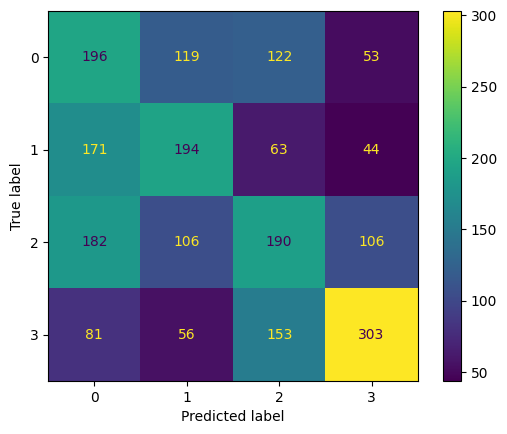

In [7]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


cm=confusion_matrix(y_test,y_test_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

# Dimensional Reduction

Try reduce to 2 features with PCA

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)
X_test_2D = pca.transform(X_test_scaled)

knn_pca = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  
knn_pca.fit(X_train_2D, y_train)

# Prediction
y_train_2D_pred = knn_pca.predict(X_train_2D)
y_test_2D_pred = knn_pca.predict(X_test_2D)

# Evaluation metrics
print("train_accuracy w/o PCA",accuracy_score(y_train,y_train_pred))
print("test_accuracy w/o PCA",accuracy_score(y_test,y_test_pred))

print("train_accuracy w/ PCA",accuracy_score(y_train,y_train_2D_pred))
print("test_accuracy w/ PCA",accuracy_score(y_test,y_test_2D_pred))

train_accuracy w/o PCA 0.5584385226741468
test_accuracy w/o PCA 0.412809724170173
train_accuracy w/ PCA 0.553763440860215
test_accuracy w/ PCA 0.41935483870967744


Conclusion: Reducing data dimension has no significant in the accuracy. Probably because our dataset not large enough, our features not large enough.

## Improvement with Hyperparameter Tuning using GridSearchCV

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# Create a pipeline to scale and apply KNN
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid
param_grid = {
    'knn__n_neighbors': range(2, 31),  # Try k from 2 to 30
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# Initialize GridSearch
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 116 candidates, totalling 580 fits
Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 25, 'knn__weights': 'uniform'}
Best cross-validation accuracy: 0.4581581793453028


In [13]:
# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.45722300140252453
Classification Report:
               precision    recall  f1-score   support

        2408       0.34      0.32      0.33       490
        2442       0.51      0.47      0.49       472
        2818       0.38      0.42      0.40       584
        3027       0.59      0.60      0.59       593

    accuracy                           0.46      2139
   macro avg       0.46      0.45      0.45      2139
weighted avg       0.46      0.46      0.46      2139



In [14]:
print("Base model accuracy:", accuracy_score(y_test, knn.predict(X_test_scaled)))  # Before tuning
print("Best model accuracy:", accuracy_score(y_test, best_model.predict(X_test_scaled)))  # After tuning

Base model accuracy: 0.412809724170173
Best model accuracy: 0.45722300140252453
